<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Classification with SciKit-Learn
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2021</b> <br>
    <b>Lab04.01 - 05/05/2021<br>
    Marco Cannici <br>
    <a href="mailto:marco.cannici@polimi.it">marco.cannici@polimi.it</a><br>
    </div>
    </td>
    <td width="100px"> 
        <a href=http://chrome.ws.dei.polimi.it/index.php?title=Machine_Learning_Bio>
        <img align="right", width="100px" src='https://chart.googleapis.com/chart?cht=qr&chl=chrome.ws.dei.polimi.it/index.php?title=Machine_Learning_Bio&chs=180x180&choe=UTF-8&chld=L|0' alt=''>
        </a>
    </td>
</tr>
</table>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
np.random.seed(0)

## The South African Heart Disease Dataset

The data represents white males between 15 and 64 years old having **presence or absence of myocardial infarction (MI)** at the time of the survey. The aim of the study, carried out in three rural areas of the Western Cape, South Africa, was to establish the intensity of ischemic heart disease risk factors in that high-incidence region.

- sbp: systolic blood pressure
- tobacco: cumulative tobacco (kg)
- ldl: low density lipoprotein cholesterol
- adiposity: a numeric vector
- famhist: family history of heart disease, a factor with levels Absent Present
- typea: type-A behavior (measure of psycho-social stress)
- obesity: a numeric vector
- alcohol: current alcohol consumption
- age: age at onset
- chd: response, coronary heart disease


In [2]:
# Read the data and creates a pandas DataFrame
pd_data = pd.read_csv("data/SAheart.csv")
# Remove extra column
pd_data = pd_data.drop('row.names', axis=1)
print(pd_data.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1


### Missing values

As usual we inspect the data to check if there are any missing values. As the regression algorithms we have seen in previous labs, all the algorithms we will use in this notebook require all the fields to have an actual value.

In [3]:
# Check how many samples with missing values there are
np.any(pd_data.isna(), axis=1).sum()
# Remove them
#pd_data = pd_data.dropna(axis=0)

0

### Categorical values

In [4]:
# Checkout values
np.unique(pd_data['famhist'])

array(['Absent', 'Present'], dtype=object)

Some features are categorical, meaning that they do not assume a numerical value and no ordering between values is trivially defined for them. E.g., we can't say `'Absent' > 'Present'`. We may have two options to handle these features:
- Convert them into a single numerical feature, i.e., assigning to each category a numerical value starting from 1, or 0
- Create a set of binary features, one for each possible value, and set to 1 only the feature corresponding to the actual sample value. This feature encoding is commonly called **one-hot**

In [5]:
def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values, n_values)
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

# Convert famhist into a one-hot encoding
pd_data_temp = onehot_feature(pd_data, 'famhist')
pd_data_temp

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Absent,famhist_Present
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1,0.0,1.0
1,144,0.01,4.41,28.61,55,28.87,2.06,63,1,1.0,0.0
2,118,0.08,3.48,32.28,52,29.14,3.81,46,0,0.0,1.0
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1,0.0,1.0
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,64,28.45,0.00,58,0,1.0,0.0
458,182,4.20,4.41,32.10,52,28.61,18.72,52,1,1.0,0.0
459,108,3.00,1.59,15.23,40,20.09,26.64,55,0,1.0,0.0
460,118,5.40,11.61,30.79,64,27.35,23.97,40,0,1.0,0.0


Since famhist has only two possible values, a batter way to handle this feature would be to convert it into a single binary feature. We usually prefer this option when the categorical feature has only two options, and the one-hot encoding when we are dealing with more than two possibilities.

In [6]:
# Replace Present/Absent with 1.0/0.0
pd_data['famhist'] = pd_data['famhist'].replace({'Present': 1.0, 'Absent':0.0})

In [7]:
print(pd_data.columns)
pd_data.head()

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1.0,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0.0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1.0,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1.0,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1.0,60,25.99,57.34,49,1


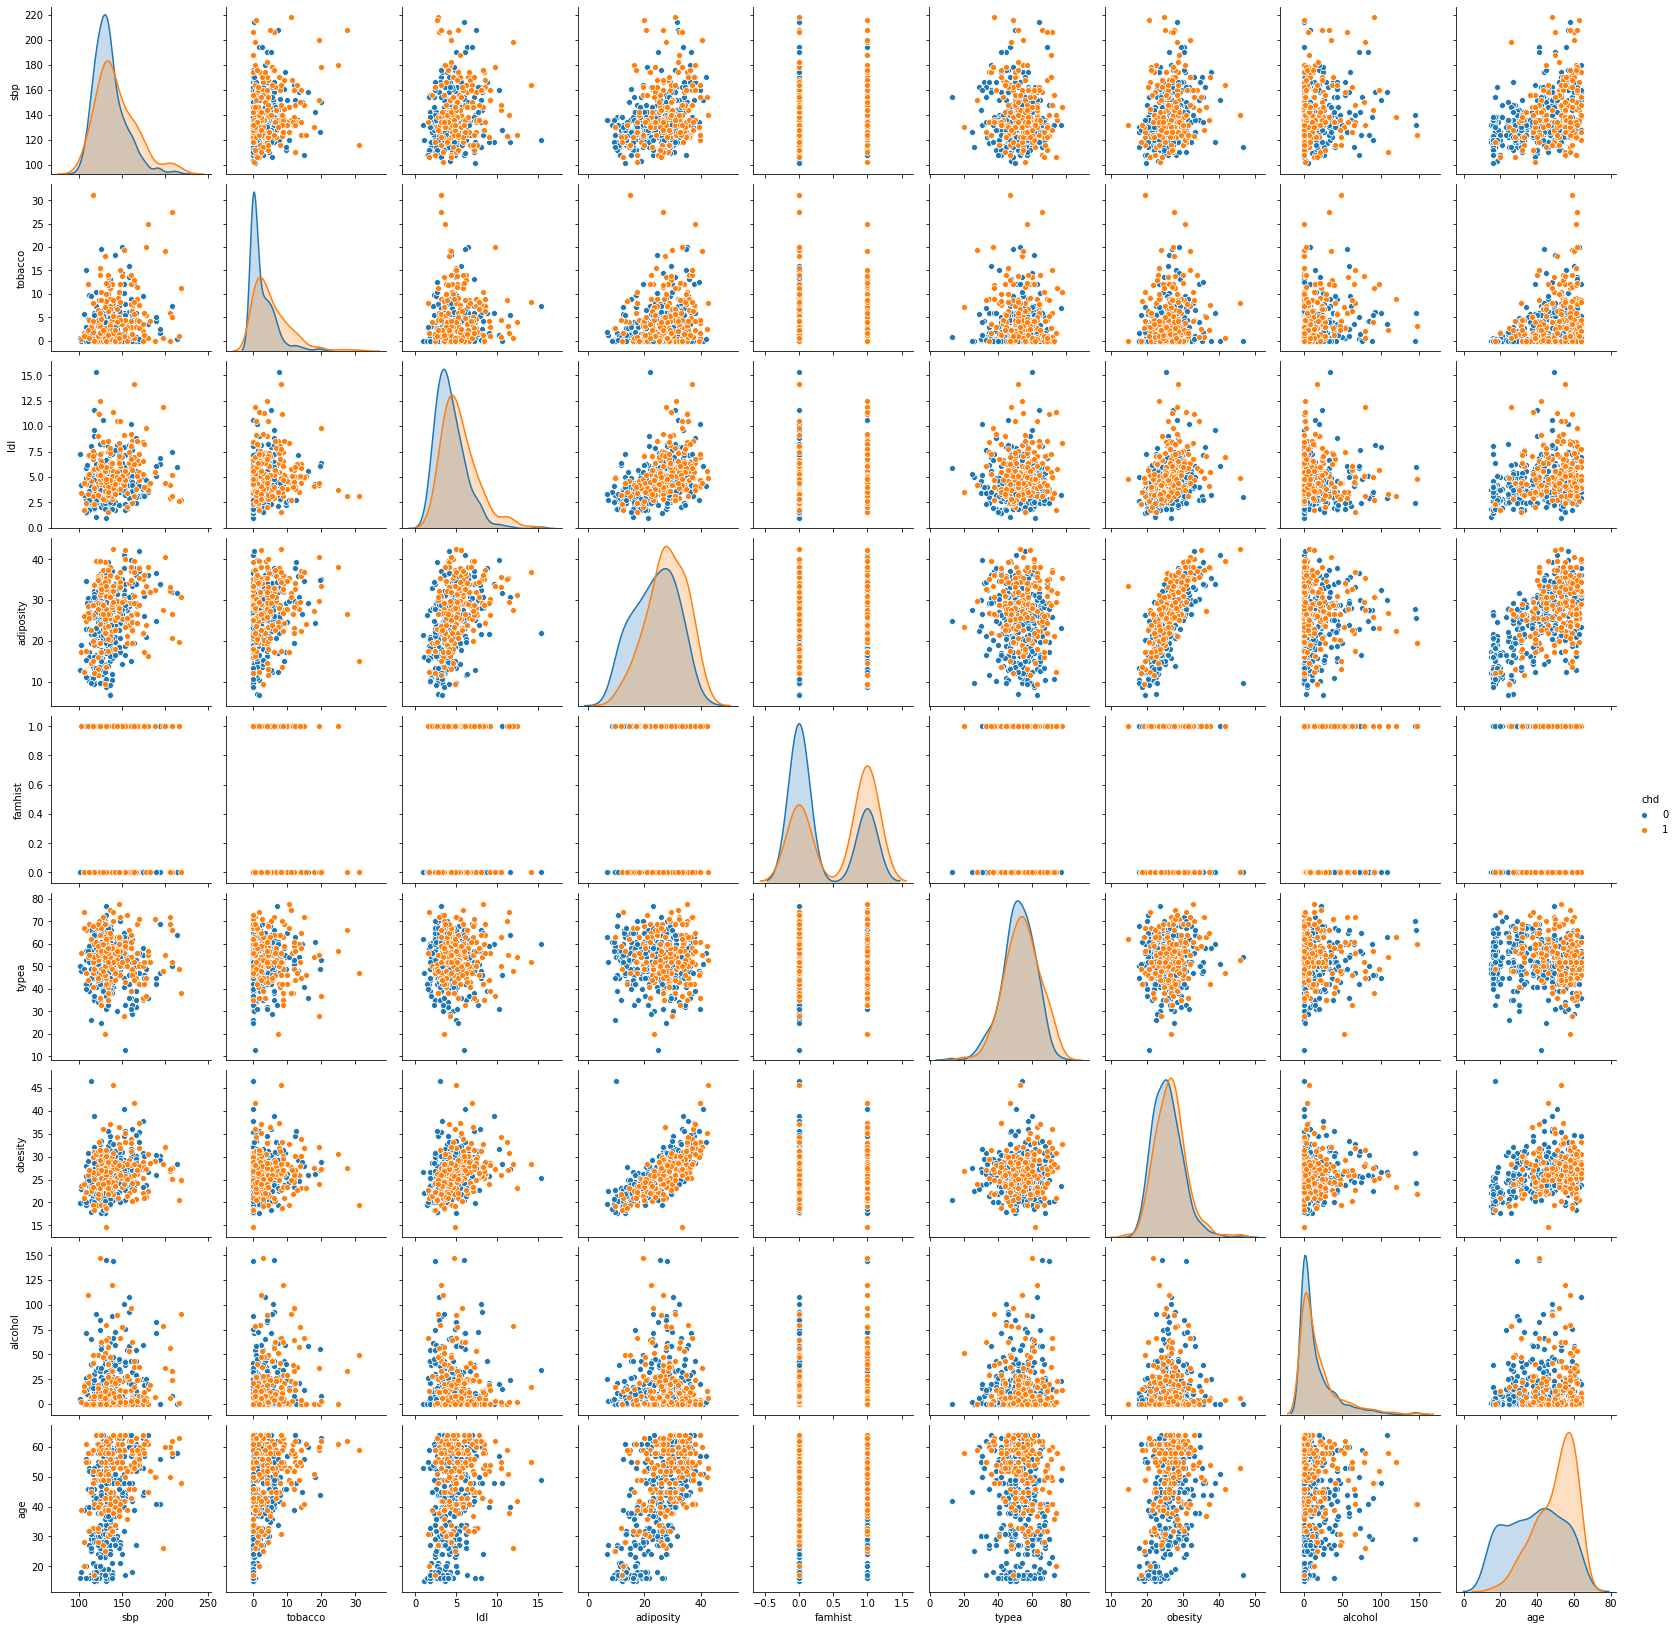

In [8]:
sns.pairplot(pd_data, hue='chd')

Another useful tool for preliminary data inspection is the **correlation matrix**, which, in simple terms, measure any statistical association between variables and commonly refers to the degree to which a pair of variables are linearly related.

$\rho_{X, Y}=\operatorname{corr}(X, Y)=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}=\frac{\mathrm{E}\left[\left(X-\mu_{X}\right)\left(Y-\mu_{Y}\right)\right]}{\sigma_{X} \sigma_{Y}}$

[0.19235411 0.29971754 0.26305268 0.25412139 0.27237273 0.10315583
 0.10009508 0.06253068 0.37297334 1.        ]


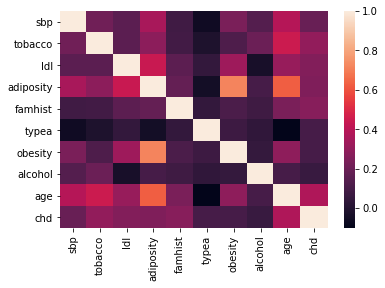

In [9]:
print(pd_data.corr().to_numpy()[:,-1])
sns.heatmap(pd_data.corr())

## Classification with Linear Regression

Let's first try to estimate the probability of CHD using a linear regressor. Since the probability is a continuous value ranging from 1 or 0, we may be tempted to use standard regression techniques to predict the probability value.

Let's focus in this first analysis on a **single feature problem** (simple linear regression/classification) and try to predict the probability CHD just from the patient **Age**. We choose Age and not one of the others for no particular reason. We observe however that among all the features, Age seems to be the one most correlated with the CHD target value (more orange-ish color). To verify this, try to inspect the chd row/column of the data correlation matrix!

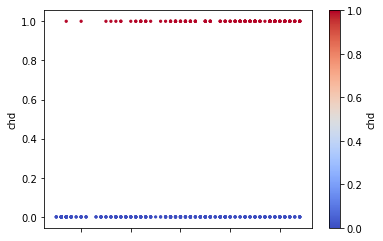

In [10]:
y = pd_data['chd'].to_numpy().astype(np.float32)
# Use Age as feature
X = pd_data[['age']]

pd_data.plot.scatter('age', 'chd', c='chd', colormap='coolwarm', marker='.')

As usual, we first split the data into training and test, since no test set is already been provided by the dataset.

In [11]:
split_seed = 42
split_test_size = 0.2

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed)

Text(0, 0.5, 'Probability of AHD')

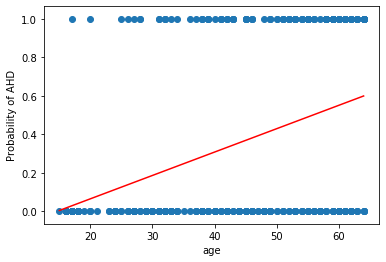

In [12]:
from sklearn.linear_model import LinearRegression  # 1- model selection
model = LinearRegression(fit_intercept=True)       # 2- hyperparams
model.fit(X_train, y_train)                        # 3- model fitting
y_predict = model.predict(X_train)                 # 4- model testing

# Plot the linear regressor boundary
x1, x2 = int(X_train.min()), int(X_train.max())
y1, y2 = model.predict([[x1], [x2]])

plt.scatter(X_train, y_train)
plt.plot([x1, x2], [y1, y2], color='r')
plt.xlabel("age")
plt.ylabel("Probability of AHD")

We already start to see some problems with this approach.
- For certain values of age (very young and onld people) we predict a probability value that exceeds the [0, 1] range
- Since the probability value is not bounded, we don't have a trivial way to convert the predicted value into a decision

We can try to perform a thresholding on the predicted probability, but what **threshold** should we use?

Text(0, 0.5, 'Probability of AHD')

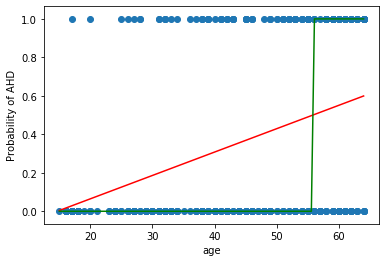

In [13]:
def hard_threshold(y_pred):
    return (y_pred > 0.5).astype(np.float32)

X_fake = np.linspace(x1,x2,100).reshape(-1, 1)
y_class = hard_threshold(model.predict(X_fake))

plt.scatter(X_train, y_train)
plt.plot([x1, x2], [y1, y2], color='r')
plt.plot(X_fake, y_class, color='g')
plt.xlabel("age")
plt.ylabel("Probability of AHD")

In [14]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.shape[0]

print("Train acc:", accuracy(y_train, hard_threshold(model.predict(X_train))))
print("Test acc:", accuracy(y_test, hard_threshold(model.predict(X_test))))

Train acc: 0.6802168021680217
Test acc: 0.6344086021505376


## Logistic Regression - Recap

The linear regressor produces < 0 probabilities for some age values; if we were to predict for very young people, we would get probabiltity values smaller than zero!

This problem is not unique to the age data. To avoid this problem, **we must model p(X) using a function that gives outputs between 0 and 1 for all values of X**. Many functions meet this description. 

In logistic regression, we solve the problem by **regressing the logistic function, which is bounded between 0 and 1**. We do this by using the _maximum likelihood_ algorithm (MLE).

$p(Y|X)=\frac{e^{\beta_{0}+\beta_{1} X}}{1+e^{\beta_{0}+\beta_{1} X}}$

This relation may not seem linear at first glance. However, what we require for the model to be linear is that its **decision boundary** is linear. Actually, we just need that a **linear monotone transformation of the posterior probabilities $P(Y|X)$ exists for the model to be linear**.

Here, the monotone transformation is the **logit** transformation $log[p/(1-p)]$:
$\quad log\left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = \beta_0 + \beta_1^T X$

The **decision  boundary** is the set of point for which the **log-odds** are zero

In [15]:
from sklearn.linear_model import LogisticRegression             # 1- model selection
model = LogisticRegression(solver="newton-cg", penalty='none')  # 2- hyperparams
model.fit(X_train, y_train)                                     # 3- model fitting

LogisticRegression(penalty='none', solver='newton-cg')

In [16]:
# Print the estimated coefficients
print("beta0 =", model.intercept_.squeeze())
print("beta1 =", model.coef_.squeeze())

beta0 = -3.5567573885164157
beta1 = 0.06433009219535929


In [17]:
print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.6802168021680217
Test accuracy: 0.6344086021505376


### Predicting probabilities and classifying

The `predict()` method of scikit-learn classifiers directly predicts the target class, i.e., a integer value from `0` to `C-1` (the total number of classes). If we want to get access to the predicted probability we can do so using the `predict_proba()` function, which returns, for each sample, a vector of probabilities, one for each possible class.

In [18]:
# Predict the CHD probability for being 10 and 70 years old
# Use predict_proba to retrieve the predicted probability
probas = model.predict_proba([[10], [70]])
# Returns P(not CHD|x)=P(0.0|x) and P(CHD|x)=P(1.0|x)
p_chd = probas[:, 1]
print("Probability of AHD for being 10 years old:", p_chd[0])
print("Probability of AHD for being 70 years old:", p_chd[1])

Probability of AHD for being 10 years old: 0.051492356603260396
Probability of AHD for being 70 years old: 0.720380353142781


### Statistical tests on the coefficients

As for Linear Regression, we can perform statistical tests of the model parameters to check if a feature is actually needed. Instead of the t-test, we will use in this case the **Z-test**. 

**Why the Z-test and not the t-test?**

The difference comes down to how the parameters are estimated. 
- While with linear regression parameters are estimated with the Least Squares procedure (where it can be proved that the difference between $\beta_i$ and its estimate $\hat{\beta}_i$ is distributed as a t-Student),
- In logistic regression parameters are obtained through MLE, where we know instead that the difference $\beta_i$ and its estimate $\hat{\beta}_i$ will be **approximately normally distributed with mean 0**.

Dividing a normal distribution with mean 0 and standard deviation $\sigma$ by its standard deviation will yield the standard normal distribution with mean 0 and standard deviation 1:

$\quad Z=\frac{\left(\hat{\beta}-\beta_{0}\right)}{\widehat{\operatorname{SE}}(\hat{\beta})} \sim \mathcal{N}(0,1)$, where $\beta_0$ is the value under the null hypotesys $\mathcal{H}_0$ we want to test.

$\widehat{\operatorname{SE}} = \sqrt{Cov_{ii}}, \quad Cov = (X^TVX)^{-1}, \quad$
$\mathbf{V}=\left[\begin{array}{cccc}
\hat{p}_{1}\left(1-\hat{p}_{1}\right) & 0 & \dots & 0 \\
0 & \hat{p}_{2}\left(1-\hat{p}_{2}\right) & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \hat{p}_{n}\left(1-\hat{p}_{n}\right)
\end{array}\right]$

Note: check out the Elements of Statistical Learning book for the derivations of Cov (second order derivative of the likelihood).


The test is performed as usual:
- we compute the Z score under the null hypothesis
- compute the p-value usign the $\mathcal{N}(0,1)$ distribution
- check the p-value against a fixed threshold


In [19]:
from scipy.stats import norm, zscore

def z_test(X, y, model, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    betas = np.concatenate([model.intercept_, model.coef_.reshape(-1)])
    
    # Compute the prediction
    pred = model.predict_proba(X) # [N, 2]
    y = y.reshape(-1)    
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    n_samples, n_features = X.shape
    
    V = np.diagflat(np.product(pred, axis=1))
    covLogit = np.linalg.inv(np.dot(np.dot(X.T, V), X))
    se_b = np.sqrt(np.diag(covLogit))
    
    z_stat_b = (betas - 0) / se_b

    # Compute the p-value (two-sided test)
    p_values = np.array([2 * norm.sf(np.abs(z_stat)) for z_stat in z_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = np.round(se_b, decimals=4)
    df["Z-stat"] = np.round(z_stat_b, decimals=1)
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    return df

z_test(X_train, y_train, model, ["Intercept", "Age"], alpha=0.0001)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-3.556757,0.4630,-7.7,1.565666e-14,True
1,Age,0.064330,0.0095,6.8,1.053975e-11,True


### Plot the linear regressor boundary

y_vals.shape = (100000, 2)


(0, 100)

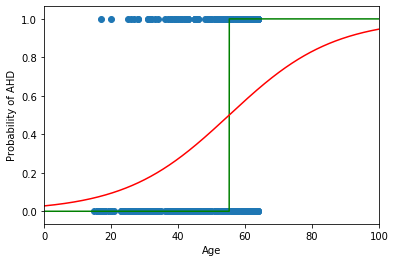

In [20]:
# Plot the linear regressor boundary
x_vals = np.linspace(start=0, stop=100, num=100000).reshape(-1,1)
y_pred = model.predict(x_vals)

# NOTE: predict() in this case returns a binary value (1.0 or 0.0)
y_vals = model.predict_proba(x_vals)
print("y_vals.shape =", y_vals.shape)

# predict_proba returns two values for each data point, providing
# both the P(C0|x) and P(C1|x). We plot the probability of class 1
y_c1 = y_vals[:,1]

plt.scatter(X_train, y_train)
plt.plot(x_vals, y_pred, color='g')
plt.plot(x_vals, y_c1, color='r')
plt.xlabel("Age")
plt.ylabel("Probability of AHD")

plt.xlim(0,100)

### Interpreting the coefficients

What is the meaning for the logistic regression?
$\quad log\left( \frac{P(Y=1|X)}{1 - P(Y=1|X)} \right) = \beta_0 + \beta_1^T X$

- If $\beta_1 = 0$, there is no relationship between X and Y, as in regression
- If $\beta_1 > 0$, when X gets larger so does the **log-odd**, and hence the probability $P(Y=1|X)$
- If $\beta_1 < 0$, when X gets smaller so does the **log-odd**, and hence the probability $P(Y=1|X)$

**What is the meaning of score $\beta_{age} = 0.064330$ ?**

**How much the probability of heart desease increases if we increase age by one year?**

$\quad \Delta log\left( \frac{P(y=1|x_{age})}{1 - P(y=1|x_{age})} \right) = (\beta_0 + \beta_1 x_{age}) - (\beta_0 + \beta_1 (x_{age}+1)) = \beta_1$

In [21]:
beta_age = model.coef_[0]
print("1 year of age increases the log odds by:", beta_age)
print("Which means increasing the odds by:", np.exp(beta_age))

1 year of age increases the log odds by: [0.06433009]
Which means increasing the odds by: [1.06644437]


Interpreting the model parameters is not so straightforward as for linear regression since the parameters don't directly act on the model output (the probability), as in regression, but on the log-odds. Since log-odds are ratio of probabilities, **the actual increase of probability depends on where "we start from" on the logit function (i.e., from which age we start from when adding 1)**.

- Increasing Age on a region where the logit functon is very flat (i.e., where the probability is near 0 or 1), won't affect too much the output probability
- Contrary, the effect will be hiher if we change Age on the central region of the logit, where the function has a linear behavior

We can plot this behaviour by inspecting how the difference $P(y|x_{age}+1) - P(y|x_{age})$ changes as a function of the starting point $x_{age}$

Text(0, 0.5, 'P(Y=1|X) increase')

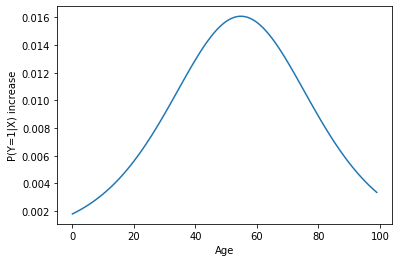

In [22]:
X_age = np.arange(0, 100).reshape(-1, 1)
proba_age = model.predict_proba(X_age)[:, 1]
proba_age1 = model.predict_proba(X_age + 1)[:, 1]
incr = (proba_age1 - proba_age)

plt.plot(X_age, incr)
plt.xlabel("Age")
plt.ylabel("P(Y=1|X) increase")

## Multiple Logistic Regression 

Notice, this must not be confused with the multi class case, where logistic regression is defined by a set of K-1 different log-odds transformations. We are still in the binary classification case but we use multiple features for predicting the class. Derivations and the learning mechanism is the same as before!

In [23]:
# Train a logistic regressor that uses all features
X_full_feat = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
#X_feat = ['tobacco', 'ldl', 'famhist', 'age']
X_full = pd_data[X_full_feat]
X_full_train, X_full_test, y_train, y_test = train_test_split(X_full, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed)

In [24]:
from sklearn.linear_model import LogisticRegression            # 1- model selection
model = LogisticRegression(solver="newton-cg", penalty='none') # 2- hyperparams
model.fit(X_full_train, y_train)                               # 3- model fitting
y_predict = model.predict(X_full_train)                        # 4- model testing

print("Train accuracy:", accuracy(y_train, model.predict(X_full_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_full_test)))

Train accuracy: 0.7425474254742548
Test accuracy: 0.7526881720430108


In [25]:
z_test(X_full_train, y_train, model, ["Intercept", *X_full_feat], alpha=0.005)

,Name,Coefficients,Standard Errors,Z-stat,p-value,reject H0
0,Intercept,-4.121962,1.0792,-3.8,0.000134,True
1,sbp,0.007381,0.0063,1.2,0.238933,False
2,tobacco,0.056152,0.0288,1.9,0.051363,False
3,ldl,0.177886,0.0626,2.8,0.004461,True
4,famhist,0.814528,0.2513,3.2,0.001188,True
5,obesity,-0.044046,0.0320,-1.4,0.169336,False
6,alcohol,0.002817,0.0055,0.5,0.610852,False
7,age,0.045750,0.0111,4.1,0.000041,True


### Feature Selection

Forward, backward and best subset selection can all be applied also to classification. *In this case we don't have adjusted metrics that are theoretically proven to resamble the actual test metric (as BIC, CP and so on for regression).* We will use the validation or cross validation accuracy (or classification error) to decide which is the best number of features to select (i.e., step 3 of the algorithm), while the train accuracy/error for selecting the candidates (step 2).

The following is the same code we developed in the previous lab, where the only difference in that we are creating a LogisticRegression object instead of a LinearRegression module. 

Python exercise: can you generalize the function to train any model by adding arguments?

In [39]:
# ===================================
#   Code from Lab03.01 - 05/05/2021
# 03.01.ScikitFeaturesSelection.ipynb
# ===================================

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

def get_val_evaluator(scorer, val_size=0.1):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=0)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    for dim in range(len(all_features)):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            # //==========================================\\
            # || ***** Difference from previous lab ***** ||
            # \\==========================================//
            model = LogisticRegression(solver="newton-cg", penalty='none')
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        # Update selected feature
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim+1, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim+1, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

............
Best model (M1) with 1 features: ['age']
M1 subset score (3.): 0.6777777777777778
............
Best model (M2) with 2 features: ['age', 'famhist']
M2 subset score (3.): 0.7237987987987988
............
Best model (M3) with 3 features: ['age', 'famhist', 'ldl']
M3 subset score (3.): 0.7263513513513514
............
Best model (M4) with 4 features: ['age', 'famhist', 'ldl', 'obesity']
M4 subset score (3.): 0.7237237237237237
............
Best model (M5) with 5 features: ['age', 'famhist', 'ldl', 'obesity', 'sbp']
M5 subset score (3.): 0.7155405405405405
............
Best model (M6) with 6 features: ['age', 'famhist', 'ldl', 'obesity', 'sbp', 'tobacco']
M6 subset score (3.): 0.7181681681681682
............
Best model (M7) with 7 features: ['age', 'famhist', 'ldl', 'obesity', 'sbp', 'tobacco', 'alcohol']
M7 subset score (3.): 0.7208708708708709


Best configuration has 3 features
Features: ['age', 'famhist', 'ldl']
Total number of trained models: 98


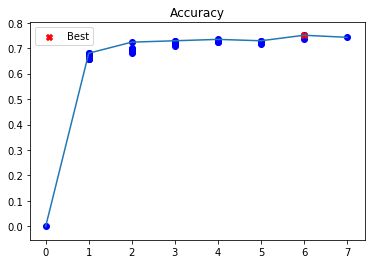

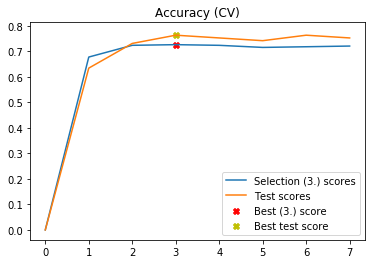

In [27]:
cv = 10
forward_selection(X_full_train, y_train, X_full_test, y_test,
                  get_evaluator(make_scorer(accuracy)), np.argmax, # 2.
                  get_cv_evaluator(make_scorer(accuracy), cv), np.argmax, # 3.
                  get_evaluator(make_scorer(accuracy)), np.argmax, # test
                  candidates_scorer_name="Accuracy",
                  subsets_scorer_name="Accuracy (CV)",
                  verbose=True, weight_step3=cv)

We obtain results that are similar to those obtained with statistical tests. Notice that this is not always the case with complex datasets, since the two methods rely on very different assumptions. We generally expect features with strong statistical tests rejection (very low p-value) to be selected first in forward feature selection compared to other ones, as it is the case of the Age and Famhist features!

## Feature selection with Lasso

As for linear regression, we can compute a "Lasso" version of the objective function that has to be minimized, by adding an L1-norm term. The effect is very similar, and, as the $\lambda$ parameters increases, will promote training of models having **sparse** parameters, i.e., where some parameters are very close to zero. 

This shrinkage effect can be used for feature selection. By gradually increasing the $\lambda$ parameter (i.e., increasing the sparsity of the model), the parameters that go to zero first will likely be the least important ones.

The `LogisticRegression` module in scikit-learn has an extra `penality` term which, if set to `'l1'`, will introduce a Lasso term in the loss. The `C` argument controls the lambda parameter in the loss (defined as the opposite of lambda): smaller values specify stronger regularization.

Note: L1-norm regularization is not available for all the solvers. The `newton-cg` solver that we used in previous examples (that is explained in the ESL book) does not support this penalty. We will use the `saga` one for this purpose (which is a variant of SAG, Stochastic Average Gradient).

Notice: to ensure parameters are within the same ranges for different lambda values, we first *normalize the data to have 0 mean and unitary standard deviation*. This does not affect the accuracy for logistic regression, but may do so for other algorithms as we will see later in this notebook.

Text(0, 0.5, 'beta')

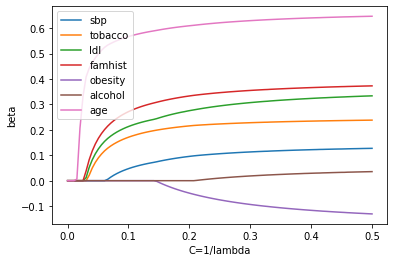

In [28]:
C_vals = np.linspace(1e-4, 0.5, 100)
betas = []

from sklearn import preprocessing
X_std = preprocessing.scale(X_full_train)

for C in C_vals:
    model = LogisticRegression(solver='saga', penalty='l1', C=C)
    model.fit(X_std, y_train)
    beta = model.coef_.reshape(-1)
    #beta = (beta - beta.min()) / beta.ptp()
    betas.append(beta)
betas = np.stack(betas, axis=1)  # [Nfeat, NCvals]

for beta, name in zip(betas, X_full_feat):
    plt.plot(C_vals, beta, label=name)
plt.legend()
plt.xlabel("C=1/lambda")
plt.ylabel("beta")

If we read the graph from left to right, that is, from very high regularization (left) to low regularization (right), we see a behaviour similar to the one observed with forward feature selection. 

- The last feature to disappear is Age, so we can think of that feature as the most important one for prediction, with famhist and ldl following.
- The first one to go to zero, instead, is alcohol, which was also the last being added to forward feature selection, and the one having the largest p-value in statistical Z-tests!

# Linear Discriminant Analysis

LDA is based on a similar concept of Logistic Regression, that is to model posterior probabilities as a **linear function of $x$**. However, the relation is found through the Bayes Theorem instead of the logistic function.

$P(Y=k|X) = \frac{P(X|Y=k) P(Y=k)}{P(X)} = \frac{P(X|Y=k) P(Y=k)}{\sum_{i=1}^{K}P(X|Y=k) P(Y=i)}$,

where $P(Y=k)$ is a prior and such that $\sum_{i=1}^{K}P(Y=i) = 1$

**LDA assumes** that:
- the density functions P(X|Y=k) of X in class K are distributed as a multivariate Gaussian 
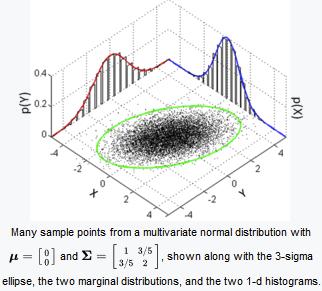
- the classes have a common covariance matrix $\Sigma$ (we have one multivariate gaussian distribution for each class $k$, all having the same covariance $\Sigma_k = \Sigma \quad\forall k$)

These assumptions allows us, while computing the log-odds, to make some semplifications (getting rid of quadratic terms) and find a **linear transformation of $x$**!

$\log \frac{\operatorname{P}(Y=k|X)}{\operatorname{P}(Y=l| X)}=
\log \frac{P(Y=k)}{P(Y=l)}-\frac{1}{2}\left(\mu_{k}+\mu_{\ell}\right)^{T} \boldsymbol{\Sigma}^{-1}\left(\mu_{k}-\mu_{\ell}\right) 
+x^{T} \boldsymbol{\Sigma}^{-1}\left(\mu_{k}-\mu_{\ell}\right)$

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA()
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.6802168021680217
Test accuracy: 0.6344086021505376


In [30]:
X_feat = ['typea', 'age']
X = pd_data[X_feat]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed)

model = LDA(store_covariance=True)
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.7046070460704607
Test accuracy: 0.6236559139784946


The **boundaries** of the classes are the values of $x$ that make the log-odds equal to 0.

If we have multiple classes we will have multiple boundaries, one for each pair of classes (indeed as many log-odds rations as we have in the previous definition, look at the $i$ and $k$ indices, it is not just one, and the same was for logistic regression!)

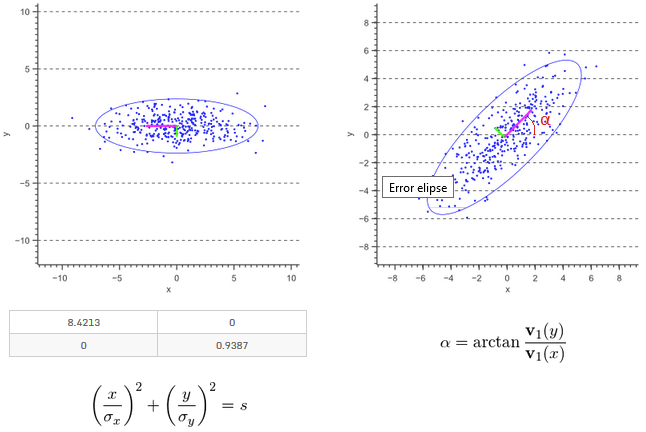

We can plot the distributions using **confidence ellipses**, which may be seen as being obtained by cutting the 3D bell shape of the gaussian with an horizontal plane, and which represent a sort of confidence interval of values. A **95% confidence ellipses** defines the region that contains 95% of all samples that can be drawn from the underlying Gaussian distribution.

- If the distribution is **axis-aligned** (covariance has values only on the diagonal), the ellipses is easy to determine since it is fully defined by the variance. The standard deviation, indeed, (squared root of the values on the covariance diagonal ) define indeed the length of the ellipses in both directions.
- If the ellipses is not **axis-aligned** we may think to **first align** it to the axis to compute the variance, and **then to rotate** it back. The align transformation can be obtained by computing the **eigenvectors** and **eigenvalues** of the covariance matrix. **Eigenvector** define the direction while **eigenvalues** the lenght of the "new axis".

In [31]:
from math import atan, degrees
from matplotlib import colors
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches

def plot_gaussian(model, mu, covar, x, y=None, n_stdev_bands=2):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if covar.ndim == 2:
        covar = np.repeat(covar[None], mu.shape[0], axis=0)
    variance, transforms = np.linalg.eigh(covar)

    ax = plt.subplot(111, aspect='equal')
    legend = []
    if mu.shape[-1] == 2:
        stdev = np.sqrt(variance)
        max_x, min_x, max_y, min_y = 0.0, 0.0, 0.0, 0.0
        cmap = cm.rainbow(np.linspace(0, 1, mu.shape[0]))
        for mean, stdev, transform, color in zip(mu, stdev, transforms, cmap):
            legend += [mpatches.Patch(color=color,
                                      label=f'mu {mean[0]:.2f}, {mean[1]:.2f} '
                                      f'sigma {stdev[0]:.2f} {stdev[1]:.2f}')]
            for j in range(1, n_stdev_bands + 1):
                ell = mpatches.Ellipse(xy=(mean[0], mean[1]),
                                       width=stdev[0] * j * 2, height=stdev[1] * j * 2,
                                       angle=degrees(atan(transform[0, 1] / transform[0, 0])),
                                       alpha=1.0,
                                       edgecolor=color,
                                       fc='none')
                ax.add_artist(ell)
                max_x = max(max_x, mean[0] + stdev[0] * j * 1.5)
                max_y = max(max_y, mean[1] + stdev[1] * j * 1.5)
                min_x = min(min_x, mean[0] - stdev[0] * j * 1.5)
                min_y = min(min_y, mean[1] - stdev[1] * j * 1.5)
    else:
        max_x, min_x = x[:, 0].max()+x[:, 0].ptp()/2, x[:, 0].min()-x[:, 0].ptp()/2
        max_y, min_y = x[:, 1].max()+x[:, 1].ptp()/2, x[:, 1].min()-x[:, 1].ptp()/2
        
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 1000),
                         np.linspace(min_y, max_y, 1000))

    X_fake = np.stack([xx, yy], axis=-1).reshape(-1, 2)    
    Z = model.predict_proba(X_fake)
    Z = Z[:, 1].reshape(xx.shape)
    
    cmap_light = colors.ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_solid = colors.ListedColormap(['#0000FF', '#FF0000'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], colors='grey')

    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_solid)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.legend(handles=legend)

    plt.show()

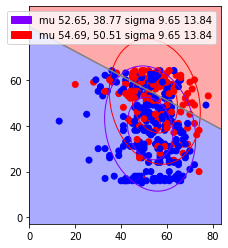

In [32]:
plot_gaussian(model, model.means_, model.covariance_, X_train, y_train)

As expected, we obtain:
- two ellipses having *the same size and orientation*, i.e., the same covariance matrix
- a straight decision boundary

## LDA with polynomial features

In the previous lab session we saw that we can obtain a quadratic (or polynomial) boundary in the input feature space by projecting the features into a higher dimensional space by converting features into polynomial ones. 

In the polynomial space, the boundary would still be linear, but it will look (and actually be) polynomial if projected back into the original input space. This procedure, as you will see, is sometimes called kernel trick.

Let's try to use quadratic polynomial features and plot the decision boundary!

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lda', LDA(store_covariance=True))])
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.7154471544715447
Test accuracy: 0.6129032258064516


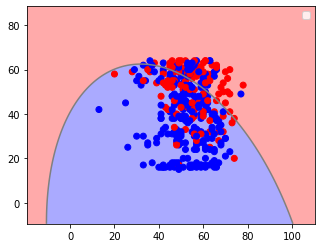

In [34]:
lda_model = model.steps[-1][-1]
plot_gaussian(model, lda_model.means_, lda_model.covariance_, X_train, y=y_train)

### What is the best degree?

As usual, if we are interested in finding the optimal hyper-parameter for an agorithm we can resort to cross-validation and gridsearch. Let's try.

In [35]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_full_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(store_covariance=True))]),
             param_grid={'poly__degree': range(1, 6)},
             scoring=make_scorer(accuracy))

In [36]:
cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017695,0.010253,0.006199,0.002961,1,{'poly__degree': 1},0.702703,0.837838,0.756757,0.783784,0.675676,0.594595,0.675676,0.648649,0.675676,0.722222,0.707357,0.066875,2
1,0.016111,0.003396,0.003634,0.001372,2,{'poly__degree': 2},0.648649,0.783784,0.729730,0.783784,0.675676,0.621622,0.702703,0.729730,0.702703,0.722222,0.710060,0.049674,1
2,0.021145,0.002785,0.003895,0.001374,3,{'poly__degree': 3},0.621622,0.729730,0.594595,0.567568,0.675676,0.540541,0.756757,0.621622,0.648649,0.694444,0.645120,0.066037,3
3,0.071342,0.009758,0.003997,0.001185,4,{'poly__degree': 4},0.567568,0.729730,0.513514,0.513514,0.675676,0.513514,0.540541,0.567568,0.459459,0.722222,0.580330,0.090253,5
4,0.250163,0.045745,0.005300,0.004172,5,{'poly__degree': 5},0.540541,0.729730,0.648649,0.567568,0.621622,0.459459,0.648649,0.567568,0.405405,0.722222,0.591141,0.099721,4


  (best 2) CV accuracy: 0.7100600600600601
  (best 2) Test accuracy: 0.7204301075268817


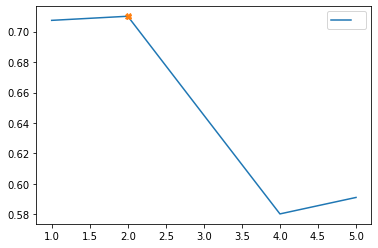

In [37]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx], 
             results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))
    
show_results(cv, X_full_test, 'param_poly__degree')

## Quadratic Discriminant Analysis

If in LDA we **remove the assumption** that density functions (multivariate gaussians distributions) must have the same covariance matrix, then we obtain a quadratic relation.

This is simply due to the fact that we cannot simpify terms while computing the boundary as we did for LDA.

Train accuracy: 0.6910569105691057
Test accuracy: 0.6451612903225806


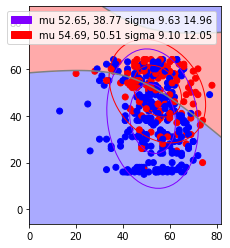

In [38]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA(store_covariance=True)
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

plot_gaussian(model, model.means_, np.stack(model.covariance_, axis=0), X_train, y_train, 2)


- The two gaussians have different sizes and orientations, suggesting a different covariance matrix
- We obtain a curve that is very similar to the one we obtained with LDA and quadratic features. Notice that here we obtain an **hyperbola**, which is still a quadratic shape!

## K-Nearest Neighbors

KNN is a non-parametric model. The algorithm is very simple:
- the training phase only consists in storing the training dataset
- at prediction, given a query point to classify, we identify the k closes training points and predict as class the most frequent class among the selected neighbors.

In [39]:
# Train a KNN with different k values
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.9728997289972899
Test accuracy: 0.6344086021505376


**Why is the train accuracy not 100% even if neighbors=1?**

In [40]:
X_train[y_train != model.predict(X_train)]

,typea,age
320,56,59
405,54,51
410,37,62
182,50,60
65,61,54
4,60,49
230,54,58
43,51,51
149,46,61
188,55,63


In [41]:
X_tmp = X_train.to_numpy()
mask = np.logical_and(X_tmp[:,0]==56, X_tmp[:,1]==59)
print(X_train[mask])
print(y_train[mask])

     typea  age
320     56   59
318     56   59
[0. 1.]


In [42]:
X_train[X_train.duplicated()]

,typea,age
403,52,58
318,56,59
412,52,55
202,57,33
182,50,60
289,55,38
197,62,42
115,46,48
127,50,38
426,57,33


In [43]:
unique_mask = y_train == model.predict(X_train)
X_train_unique = X_train[unique_mask]
y_train_unique = y_train[unique_mask]

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_unique, y_train_unique)

print("Train accuracy:", accuracy(y_train_unique, model.predict(X_train_unique)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 1.0
Test accuracy: 0.6451612903225806


### Visualize the decision boundary

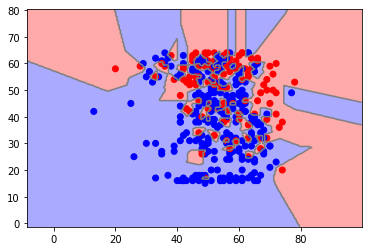

In [44]:
from matplotlib.colors import ListedColormap

def show_boundary(model, X, y=None):
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    # Note: we add a small margin (of 1) around the min and max
    max_x, min_x = X[:, 0].max()+X[:, 0].ptp()/3, X[:, 0].min()-X[:, 0].ptp()/3
    max_y, min_y = X[:, 1].max()+X[:, 1].ptp()/3, X[:, 1].min()-X[:, 1].ptp()/3
    # Create a fake dataset to evaluate the KNN output in each
    # point of the 2D space
    # 1- Create a grid of coordinates
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 300),
                         np.linspace(min_y, max_y, 300))

    # 2- Stack the coordinates to create a fake dataset to evaluate
    X_grid= np.stack([xx.reshape(-1), yy.reshape(-1)], axis=-1)
    # 3- Predict the KNN output in each point
    predict_grid = model.predict(X_grid)

    # 3- Put the result into a color plot
    predict_grid = predict_grid.reshape(xx.shape)
    plt.figure()
    # Create a color map associating colors to labels
    cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_solid = ListedColormap(['#0000FF', '#FF0000'])
    plt.pcolormesh(xx, yy, predict_grid,
                   cmap=cmap_light)#, norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, predict_grid, [0.5], colors='grey')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_solid)
    
    # plt.xlim(50,70)
    # plt.ylim(40,60)

show_boundary(model, X_train_unique, y_train_unique)

### KNN full model - Hyperparameter Selection

As usual we can use grid search and cross validation to select the best K for the dataset. In this case
- a large value of K results in a smoother boundary
- a small value of K in a more complex model

In [45]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 15)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_full_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 15)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=make_scorer(accuracy), verbose=0)

  (best 11) CV accuracy: 0.6856606606606607
  (best 11) Test accuracy: 0.5913978494623656


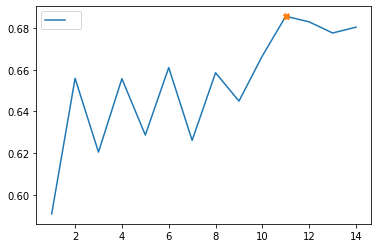

In [46]:
show_results(cv, X_full_test, "param_n_neighbors")

## Does feature normalization matter?

KNN relies on sample distances to perform prediction. In most cases, having normalized features that all span on the same range allow samples to be compared more reliably.

We usually have two options for normalizing features:
- range normalization: $x' = \frac{x - x_{min}}{x_{max} - x_{min}}$ which makes all the features have values between $[0, 1]$
- z-score normalization: $x' = \frac{x - \mu}{\sigma}$ which make features have 0 mean and unitary variance

Let's try both and check how the cross validation accuracy changes 

 Unnormalized (best 11) CV accuracy: 0.6856606606606607
 Unnormalized (best 11) Test accuracy: 0.5913978494623656
 StandardScaler (best 16) CV accuracy: 0.7127627627627627
 StandardScaler (best 16) Test accuracy: 0.7311827956989247
 MinMaxScaler (best 17) CV accuracy: 0.737087087087087
 MinMaxScaler (best 17) Test accuracy: 0.7526881720430108


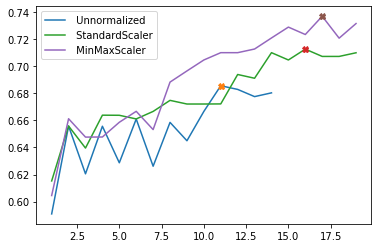

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

params = {'knn__n_neighbors': range(1, 20)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(accuracy))
cv_std.fit(X_full_train, y_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(accuracy))
cv_minmax.fit(X_full_train, y_train)

show_results(cv, X_full_test, "param_n_neighbors", prefix="Unnormalized")
show_results(cv_std, X_full_test, 'param_knn__n_neighbors', "StandardScaler")
show_results(cv_minmax, X_full_test, 'param_knn__n_neighbors', "MinMaxScaler")

## Which is the best model?

Finally, let's compare all the models using the full set of features

lda CV score: 0.7074,  test score 0.7527
lda_poly CV score: 0.7101,  test score 0.7204
qda CV score: 0.6830,  test score 0.6989
knn CV score: 0.6857,  test score 0.5914
knn_std CV score: 0.7128,  test score 0.7312
knn_minmax CV score: 0.7371,  test score 0.7527


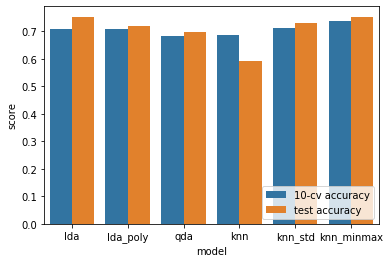

In [48]:
lda = LDA()
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA(store_covariance=True))])
qda = QDA()
knn = KNeighborsClassifier(n_neighbors=11)
knn_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=16))])
knn_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=17))])

from collections import OrderedDict
models = OrderedDict([('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('knn', knn), ('knn_std', knn_std), ('knn_minmax', knn_minmax)])

cv_scores, test_scores = [], []
for name, model in models.items():
    scores = cross_val_score(model, X_full_train, y_train, 
                             scoring=make_scorer(accuracy), cv=10)
    cv_score = np.mean(scores)
    cv_scores.append(cv_score)
    
    model.fit(X_full_train, y_train)
    test_score = accuracy(y_test, model.predict(X_full_test))
    test_scores.append(test_score)
    print("{} CV score: {:.4f},  test score {:.4f}".format(name, cv_score, test_score))

data = pd.DataFrame()
data['model'] = list(models.keys()) * 2
data['metric'] = ['10-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(test_scores)
data['score'] = cv_scores + test_scores

sns.barplot(x='model', y='score', data=data, hue='metric')
plt.legend(loc='lower right')